# Another 1D GP Example

We generate realizations of a simple one dimensional Gaussian Process with zero mean and Matérn covariance. Then we use the LaplaceInterpolation procedure to produce the interpolation.

## Generate some data with Matèrn covariance 

We use the GaussianProcesses.jl package to first make up a GP and then generate realizations from it. The parameters given to this package are on a log scale. 

In [1]:
using GaussianProcesses, LaplaceInterpolation, Random, LinearAlgebra
using Plots, Statistics, StatsPlots, BenchmarkTools
Random.seed!(20140430);

In [2]:
function sqdist(r, interp, discard)
    return sum(abs2, r[discard] .- interp[discard])
end

sqdist (generic function with 1 method)

## A single realization on a toy example

In [17]:
# Training data
n = 10
n2 = 20
v = Float64.(randperm(n2))
x = sort(v[1:n])
y = sin.(2π * x * 0.1) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
ll = 0.5
lσ = 0.0 #0.05

nrealiz = 1

# Aspect ratio
h = 1.0

# Dimension, Matern parameter, etc
d = 1
# m = nu + d/2
m = 2 
# epsilon = sqrt(2*nu)/length_scale
epsilon = sqrt(3)/exp(ll)

# Generate a single realization of the gp
gp = GP(x, y, MeanZero(), Matern(ν, ll, lσ) )
realiz = rand(gp, 1.0:n2, nrealiz);

## Interpolate using Matérn and Laplace interpolation

Here we assume the Matérn parameters are known and interpolate using them. We need to convert between the log-parameters given to the GP function above and the notation we've used, m, and $\epsilon$. 

In [18]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1)
μ     = predict_y(GP(x, realiz[keep], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1];

Plotting the realization atop the simple 1D GP.

Squared distance between Laplace interpolation and the truth: 3.1793614712047122
Squared distance between Matern interpolation and the truth: 3.250137524297169
Squared distance between GP Matern interpolation and the truth: 4.546378971952971


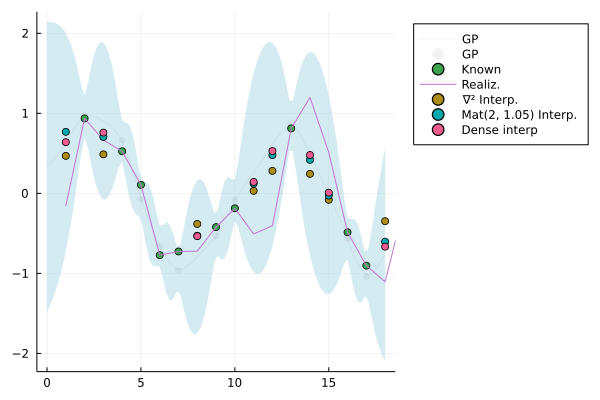

In [22]:
println("Squared distance between Laplace interpolation and the truth: $(sqdist(realiz, y_lap, discard))")
println("Squared distance between Matern interpolation and the truth: $(sqdist(realiz, y_mat, discard))")
println("Squared distance between GP Matern interpolation and the truth: $(sqdist(realiz, μ, 1:10))")

plot(gp, label = "GP", alpha = 0.05, legend = :outertopright, xlims = [0, maximum(x) + 1])
scatter!(keep, realiz[keep], label="Known")
plot!(realiz, label = "Realiz.")
scatter!(discard, y_lap[discard], label = "∇² Interp.")
scatter!(discard, y_mat[discard], label = "Mat($m, $(round(epsilon, sigdigits = 3))) Interp.")
scatter!(discard, μ, label = "Dense interp")


# Statistical Averages

Clearly, we cannot say anything about the general behavior of such an approximation with just one realization.

## Generate more data

Need to generate more data and vary both size of the data and roughness. We will benchmark the code. 

In [23]:
# Training data
n = 100
n2 = 1000
v = Float64.(randperm(n2))
x = sort(v[1:n])
y = sin.(2π * x * 0.01) + 0.05*randn(n)

keep = Int64.(x)
discard = sort(Int64.(v[(n+1):n2]))

# The Matern parameters are set on a log scale
ν = 1.5
#ll = 0.5
#lσ = 0.0 #0.05
nrealiz = 1000
m = 2

gp = GP(x, y, MeanZero(), Matern(ν, ll, lσ) )
realiz = rand(gp, 1.0:n2, nrealiz);

## Benchmark the interpolation

### Laplace interpolation

In [32]:
lt = @benchmark matern_1d_grid(realiz[:,1], discard, 1, 1.0, h)

BechmarkTools.Trial: 5855 samples with 1 evaluations.
 Range (min … max):  603.397 μs …   8.716 ms  ┊ GC (min … max): 0.00% … 66.02%
 Time  (median):     759.769 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   846.450 μs ± 686.325 μs  ┊ GC (mean ± σ):  7.58% ±  8.19%

   █▅                                                            
  ▇██▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▂▂▂▂ ▂
  603 μs           Histogram: frequency by time          5.7 ms <

 Memory estimate: 1.56 MiB, allocs estimate: 145.

### Matérn interpolation

In [33]:
mt = @benchmark matern_1d_grid(realiz[:,2], discard, m, epsilon, h)

BechmarkTools.Trial: 4934 samples with 1 evaluations.
 Range (min … max):  789.492 μs …   6.590 ms  ┊ GC (min … max): 0.00% … 59.70%
 Time  (median):     932.273 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):     1.005 ms ± 562.588 μs  ┊ GC (mean ± σ):  5.66% ±  8.30%

  ▇▇█▆▂                                                         ▁
  ██████▇▆▃▄▁▃▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▄▄▅▃▄▃▃▃▃▁▅▄▃▄▅▄▅▃▅▅▃▆▄▅ █
  789 μs        Histogram: log(frequency) by time       4.89 ms <

 Memory estimate: 1.94 MiB, allocs estimate: 146.

### Dense (GP) Interpolation

In [34]:
gpt = @benchmark predict_y(gp, Float64.(discard))

BechmarkTools.Trial: 5147 samples with 1 evaluations.
 Range (min … max):  762.012 μs …   9.640 ms  ┊ GC (min … max): 0.00% … 89.54%
 Time  (median):     864.019 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   968.683 μs ± 750.577 μs  ┊ GC (mean ± σ):  7.79% ±  8.98%

  █▇▆▂▁                                                         ▁
  █████▇▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄ █
  762 μs        Histogram: log(frequency) by time       7.65 ms <

 Memory estimate: 900.77 KiB, allocs estimate: 8109.

In [43]:
mgpt.time

968682.5140858752

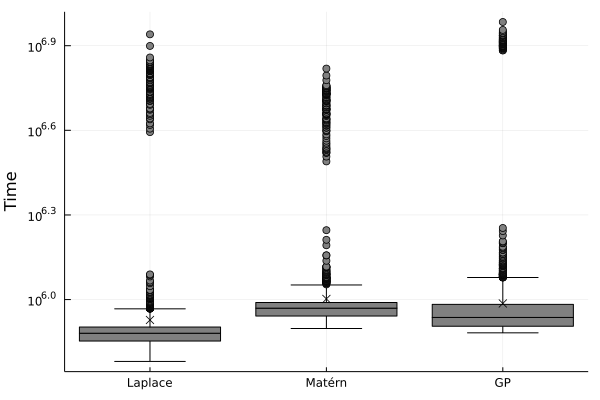

In [44]:
mlt = mean(lt).time
mmt = mean(mt).time
mgpt = mean(gpt).time
pt = boxplot([lt.times, mt.times, gpt.times], label = ["Laplace" "Matern" "GP"], ylabel = "Time",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray, yscale = :log10)
scatter!(pt, 1:3, [mlt, mmt, mgpt], markershape = :x , c = :black, label = "Mean")

## Accuracy of the approximation

In [27]:
y_lap = mapslices(z -> matern_1d_grid(z, discard, 1, 1.0, h), realiz, dims = 1)
y_mat = mapslices(z -> matern_1d_grid(z, discard, m, epsilon, h), realiz, dims = 1);
μ = mapslices(z -> predict_y(GP(x, z[keep, 1], MeanZero(), Matern(ν, ll, lσ)), Float64.(discard))[1], realiz, dims = 1)

900×1000 Array{Float64,2}:
 0.714184     0.49977      0.577872     …  0.596453     0.727285
 0.715818     0.500402     0.578723        0.597694     0.727943
 0.382484     0.266174     0.308118        0.319076     0.386587
 0.189006     0.128468     0.149433        0.156934     0.185001
 0.107352     0.0657888    0.0782566       0.087404     0.090942
 0.10362      0.0502882    0.0633532    …  0.0811796    0.0617646
 0.175421     0.0720361    0.095176        0.134275     0.0787855
 0.351546     0.137666     0.184562        0.267486     0.144752
 0.656646     0.254631     0.342428        0.499065     0.265607
 0.654483     0.252074     0.339805        0.497823     0.264913
 0.345233     0.130201     0.176906     …  0.263859     0.142727
 0.159333     0.0530113    0.0756641       0.125032     0.0736246
 0.0641256    0.0035817    0.0154514       0.0584874    0.0490941
 ⋮                                      ⋱               
 0.0025363    0.0411331    0.0551121       0.00107143   0.0728787
 

Looking at one of the realizations and the interpolation we get, we see that the squared distance between the interpolation and the truth is smaller for the Matérn.

Mean squared distance between the Laplacian interpolation and the truth: 812.0503049612328.
Mean squared distance between the Matern interpolation and the truth: 784.5669740055324.
Mean squared distance between the GP interpolation and the truth: 783.1613511632185.


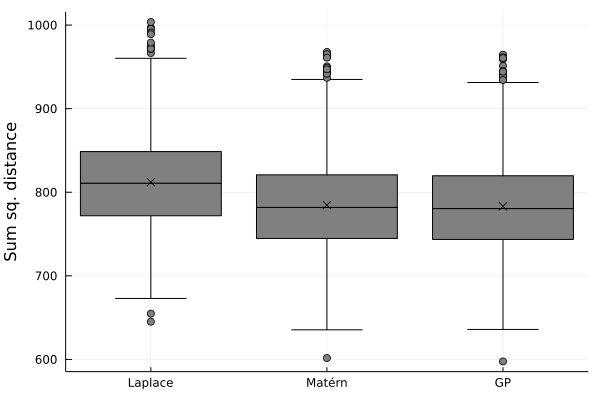

In [31]:
# Compute the squared distance for all the interpolations
lap_dist = map(i -> sqdist(realiz[:, i], y_lap[:, i], discard), 1:nrealiz)
mat_dist = map(i -> sqdist(realiz[:, i], y_mat[:, i], discard), 1:nrealiz)
gp_dist = map(i -> sqdist(realiz[discard, i], μ[:, i], 1:(n2-n)), 1:nrealiz)

ml = mean(lap_dist)
mm = mean(mat_dist)
mgp = mean(gp_dist)

println("Mean squared distance between the Laplacian interpolation and the truth: $(mean(lap_dist)).")
println("Mean squared distance between the Matern interpolation and the truth: $(mean(mat_dist)).")
println("Mean squared distance between the GP interpolation and the truth: $(mean(gp_dist)).")

p1 = boxplot([lap_dist, mat_dist, gp_dist], label = ["Laplace" "Matern" "GP"], ylabel = "Sum sq. distance",
        xtick = ([1.0, 2.0, 3.0], ["Laplace", "Matérn", "GP"]), legend = false, c = :gray)
scatter!(p1, 1:3, [ml, mm, mgp], markershape = :x , c = :black, label = "Mean")